In [1]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

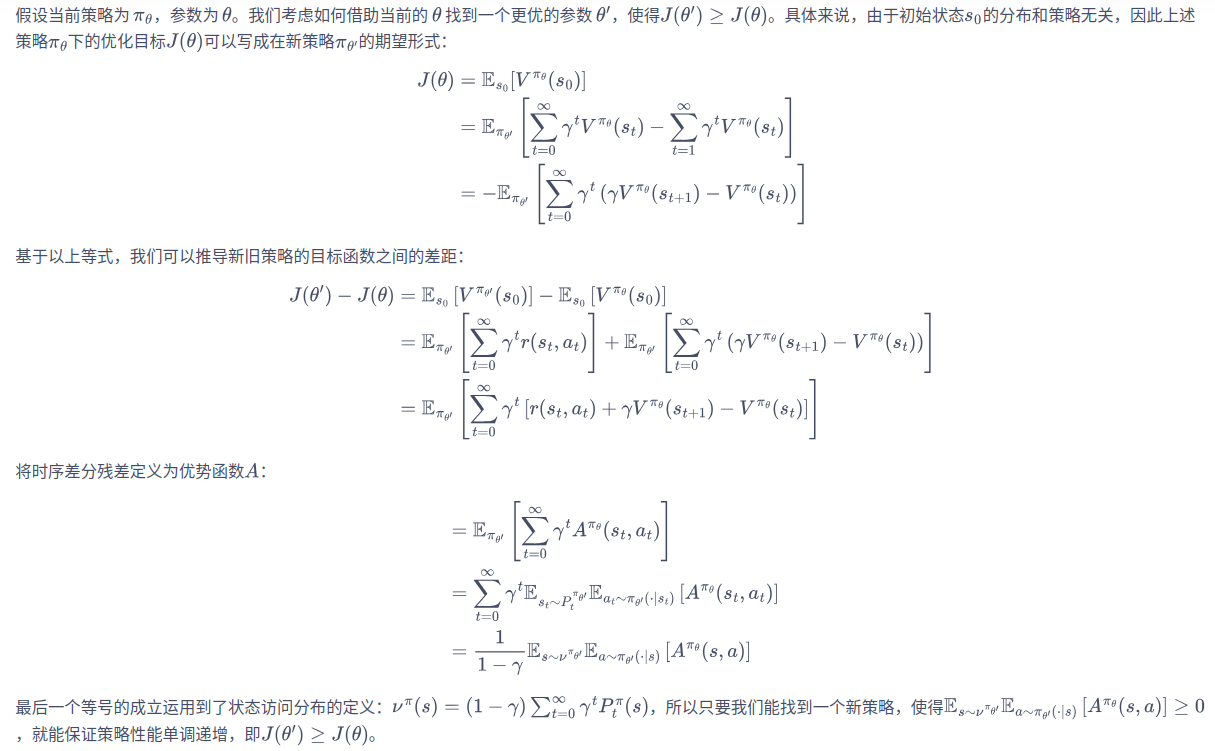
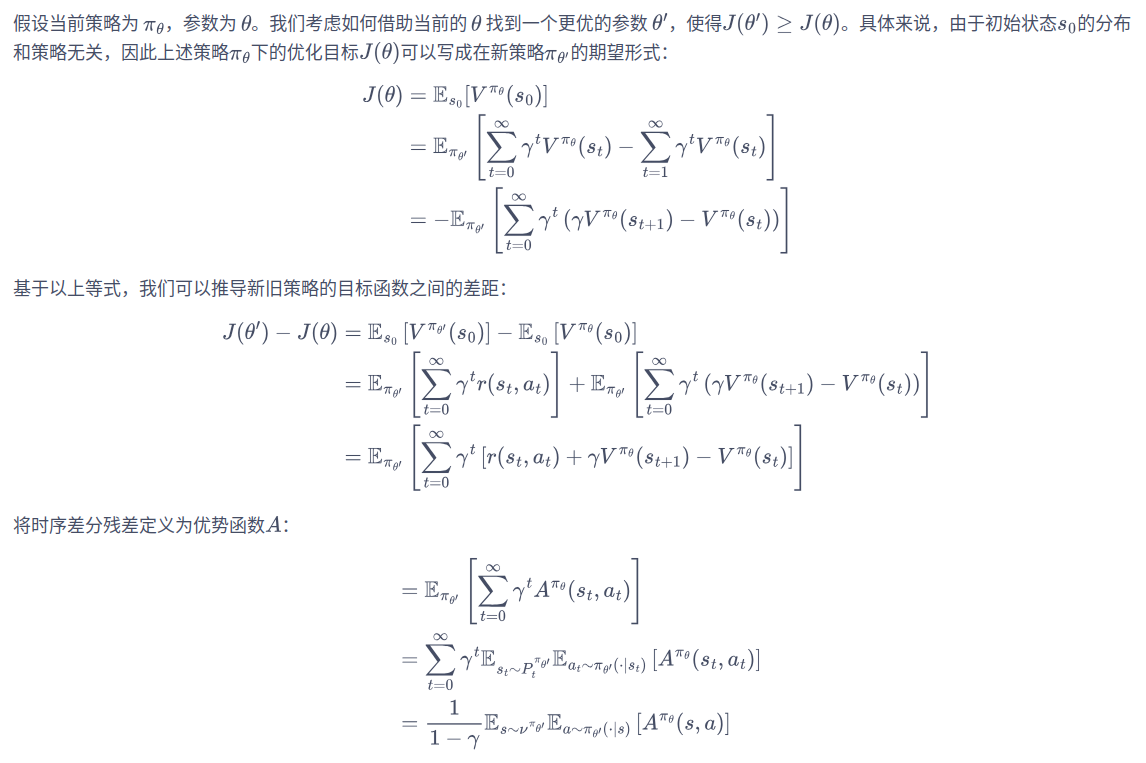

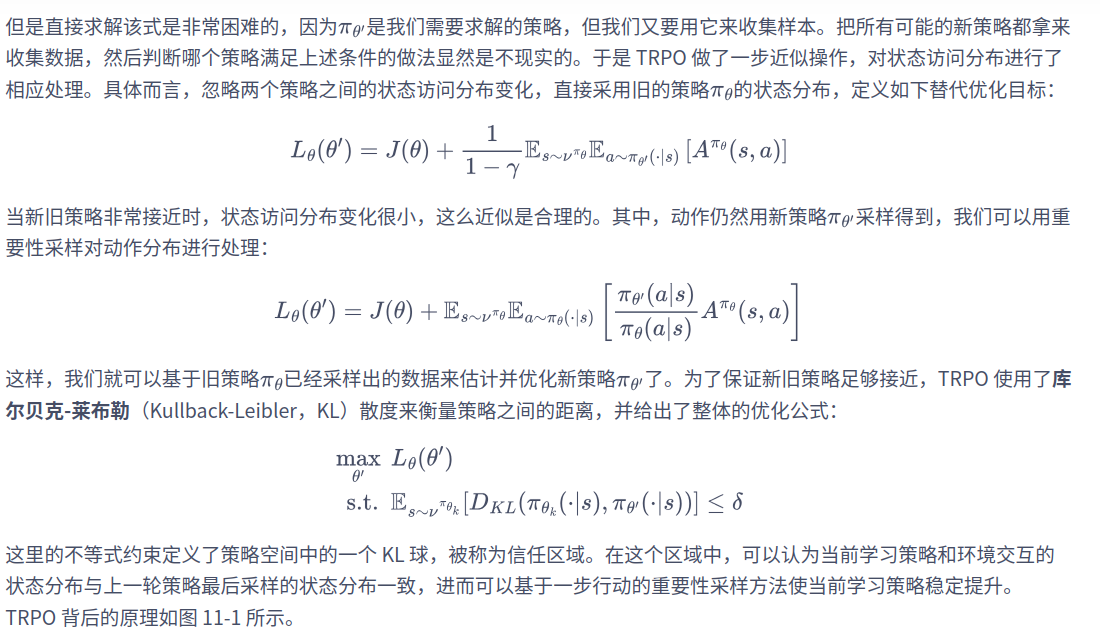  
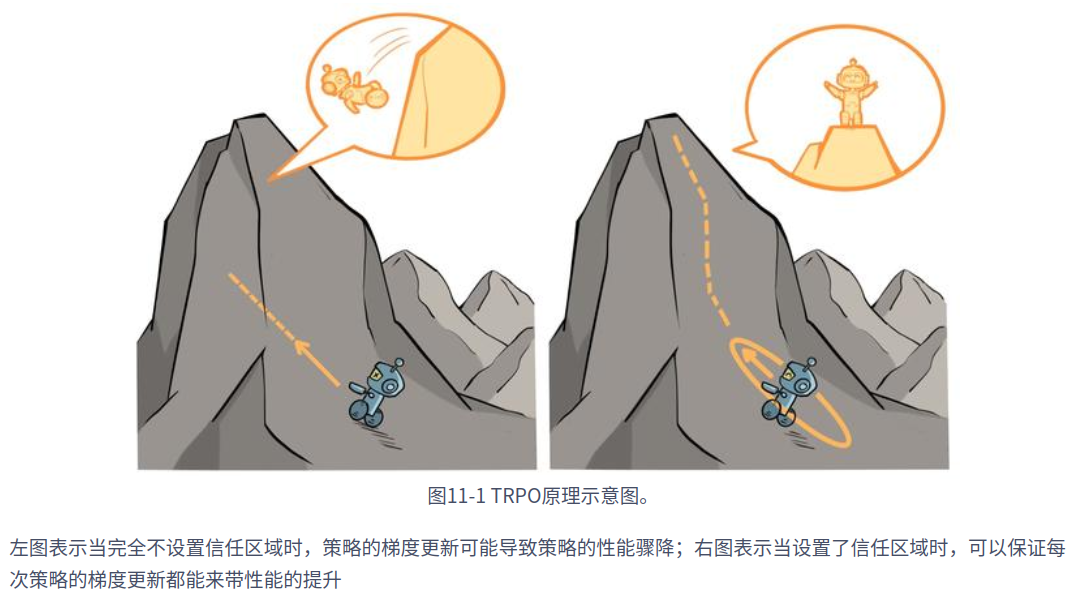  
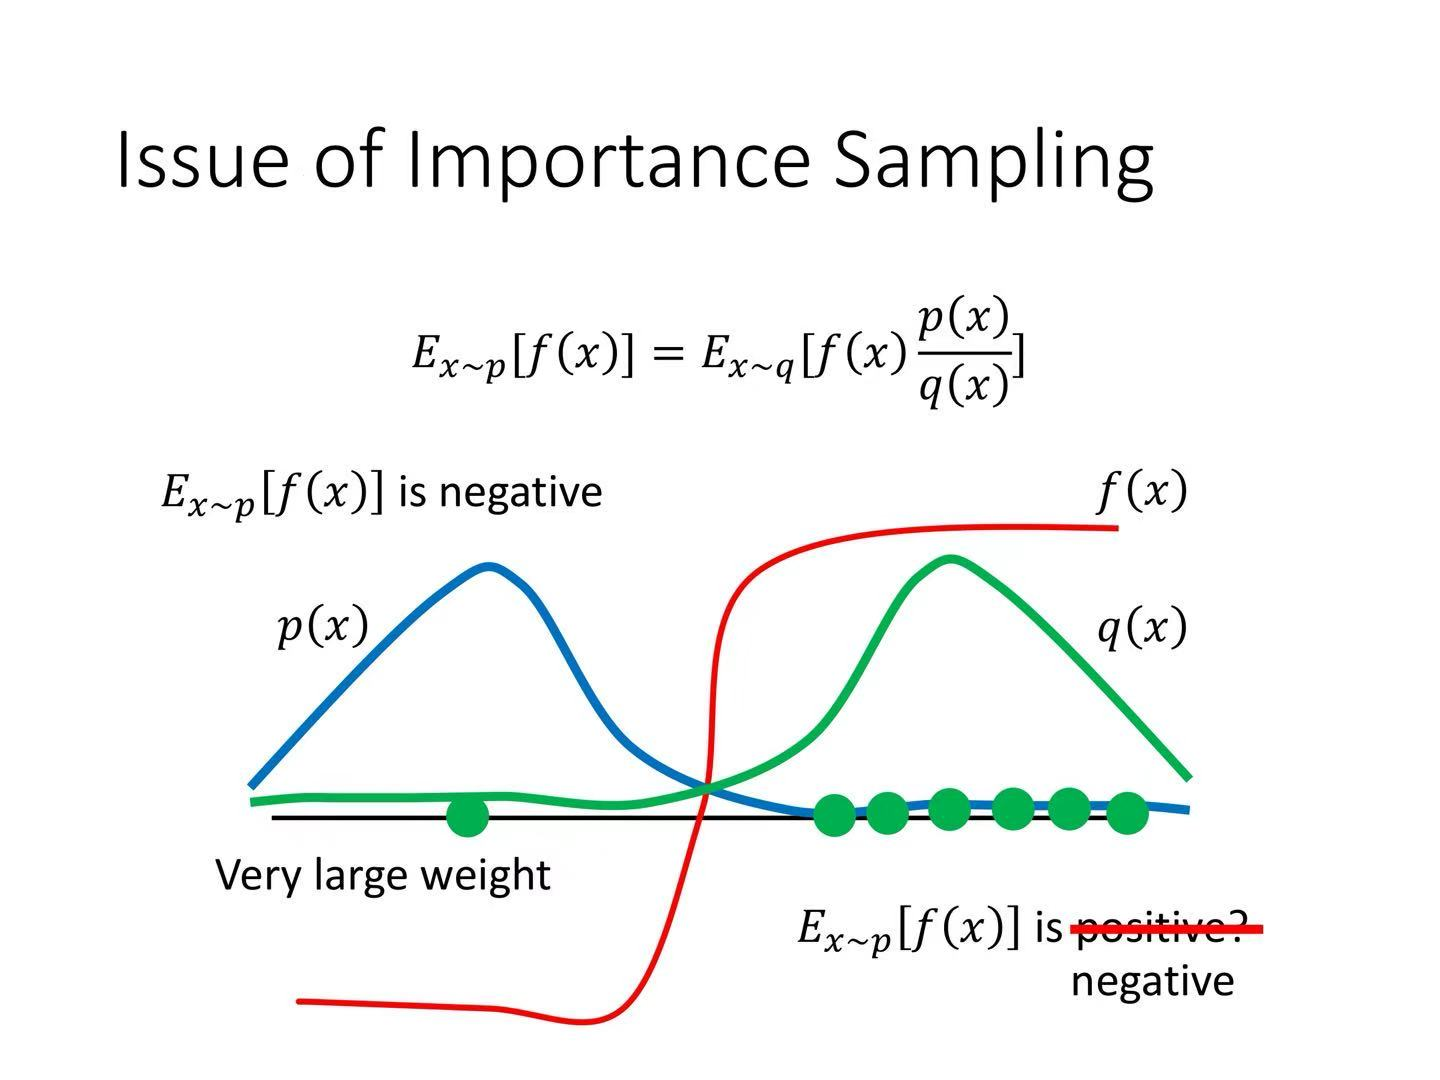

也就是说，限制$\pi_{\theta '}(a|s)$与$\pi_{\theta}(a|s)$分布不会相差太多，否则重要性采样得到的结果会不对

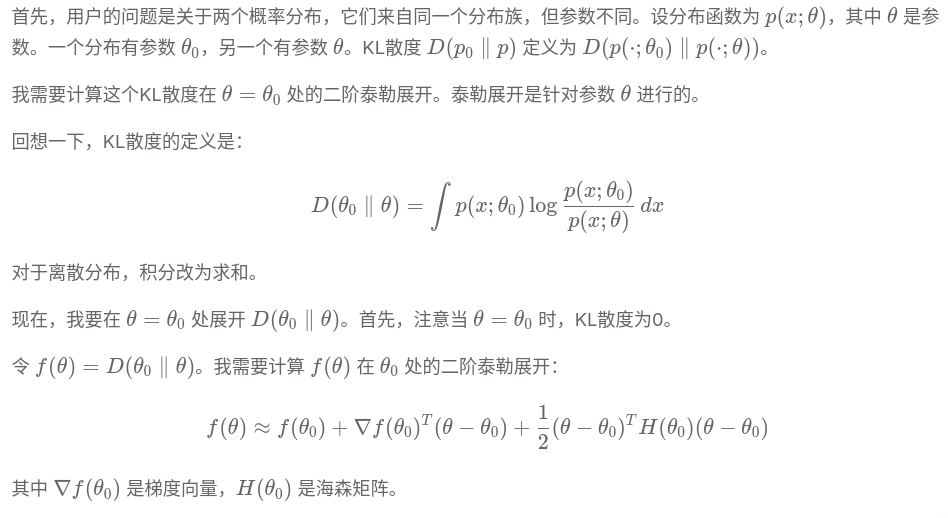  
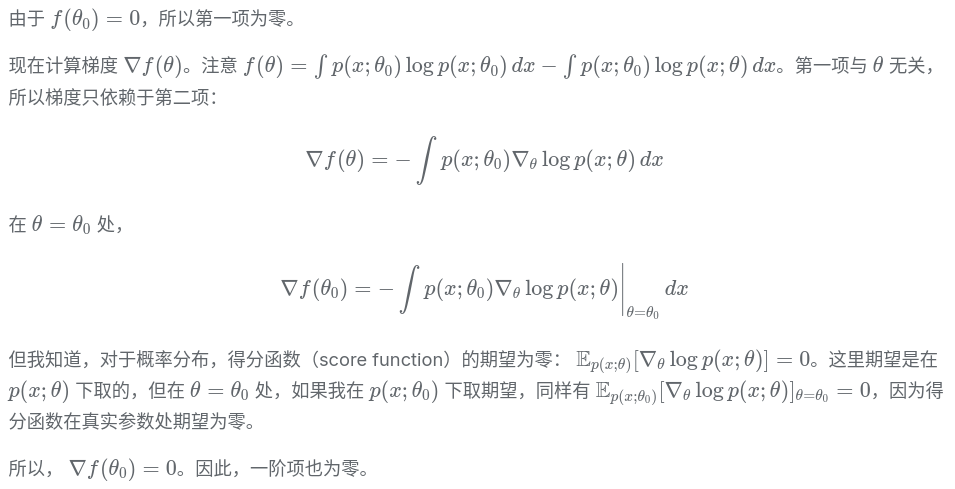  
$$D_{KL}(\pi_{\theta_{0}},\pi_{\theta})=\underset{a|s}{\sum}\pi_{\theta_{0}}(a|s)*log(\frac{\pi_{\theta_{0}}(a|s)}{\pi_{\theta}(a|s)})$$
$\theta$是变量，将$D_{KL}(\pi_{\theta_{0}},\pi_{\theta})$在$\theta_{0}$进行二阶泰勒展开：  
$$D_{KL}(\pi_{\theta_{0}},\pi_{\theta})=D_{KL}(\pi_{\theta_{0}},\pi_{\theta_{0}})+\underset{a|s}{\sum}-\frac{\pi_{\theta_{0}}(a|s)}{\pi_{\theta_{0}}(a|s)}(\theta-\theta_{0})+\frac{1}{2}(\theta-\theta_{0})^TH_{\theta=\theta_{0}}(\theta-\theta_{0})$$
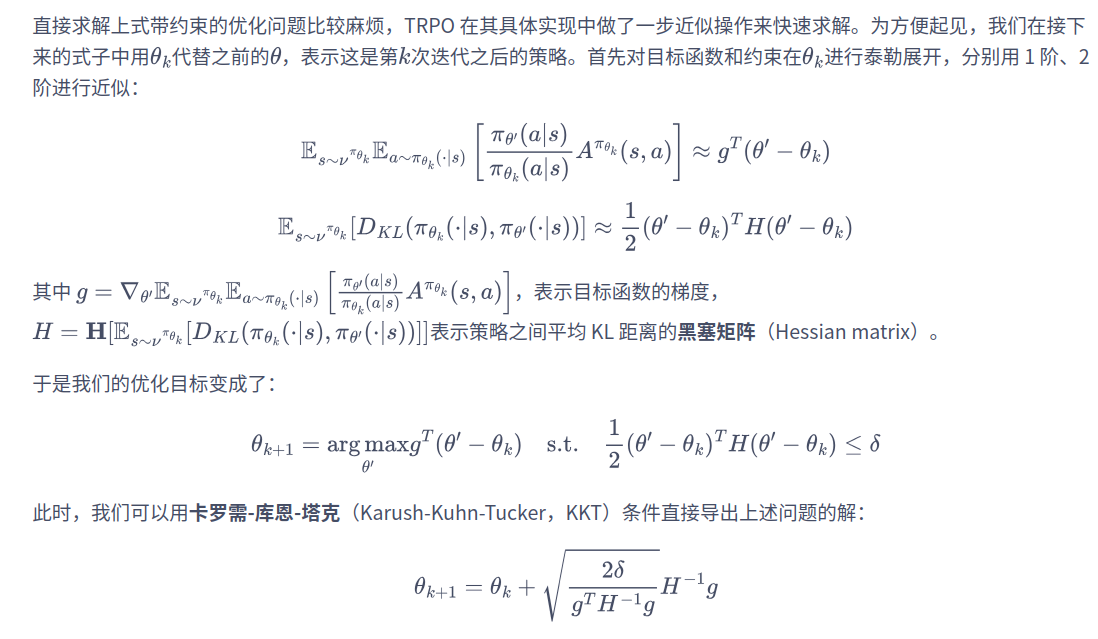  

一般优化问题：
$$\underset{x}{min}f(x)$$
$\text{subject to}:$  
$$G(x)<=0$$
$$H(x)=0$$
kkt条件(5条)：  
1.在最优解处满足拉格朗日函数梯度为0：
$L(x)=f(x)+\lambda^TG(x)+\mu^TH(x)$  
$\nabla_{x}L(x*)=\nabla_{x}f(x*)+\lambda^T\nabla_{x*}G(x*)+\mu^T\nabla_{x}H(x*)=0$  
2.等式约束可行性：$H(x*)=0$  
3.不等式子约束可行性：$G(x*)<=0$  
4.互补松弛：$\lambda^TG(x*)=0$  
5.对偶可行性：$\lambda>=0$  

TRPO算法进行了凸近似，目标函数为线性，约束为二次，凸优化：  
$\underset{x}{min}f(x)$  
$\text{subject to}:$  
$G(x)<=0$  

KKT条件退化为：  
$\nabla_{x}f(x*)+\lambda^T\nabla_{x}G(x*)=0$  
$G(x*)<=0$  
$\lambda>=0$  
$\lambda^TG(x*)=0$  

代入具体式子($\lambda$变成了标量)：  
$-g+\lambda*H*(\theta-\theta_0)=0$  
$\frac{1}{2}(\theta-\theta_{0})^TH_{\theta=\theta_{0}}(\theta- \theta_{0})-\delta<=0$  
$\lambda>=0$  
$\lambda*(\frac{1}{2}(\theta-\theta_{0})^TH_{\theta=\theta_{0}}(\theta-\theta_{0})-\delta)=0$  

$g$不会是0，也就是说最优解在边界上，$G(x*)=0$,即：  
$\theta-\theta_0=\frac{1}{\lambda}*H^{-1}g$  
$\frac{1}{2}(\theta-\theta_{0})^TH_{\theta=\theta_{0}}(\theta-\theta_{0})=\delta$  
上面$\theta-\theta_0$代入下面:  
$\frac{1}{2 \lambda^2}(H^{-1}g)^TH_{\theta=\theta_{0}}(H^{-1}g^T)=\delta$  
$\frac{1}{2 \lambda^2}g^TH_{\theta=\theta_{0}}g=\delta$  
因此有：
$\lambda=\sqrt{\frac{g^THg}{2\delta}}$  
最终：  
$\theta_{k+1}=\theta_k+\frac{1}{\lambda}*H^{-1}g=\theta_k+\sqrt{\frac{2\delta}{g^THg}}*H^{-1}g$  


$\sqrt{\frac{2\delta}{g^THg}}*H^{-1}g$要求逆，此处令$d=H^{-1}g$,可得：  
$\theta_{k+1}=\theta_k+\sqrt{\frac{2\delta}{d^THd}}*d$  
d可以看作梯度更新方向，$\sqrt{\frac{2\delta}{d^THd}}$看作步长  
求解方程$Hd=g$，得到d  

即为求解优化问题：  
$\underset{d}{min}f(d)=\frac{1}{2}d^THd-g^Td$  
最小值点梯度为0：$\nabla_{d}f(d*)=Hd-g=0$  

算法推导过程如下：  
1.初始梯度：$P_0=\nabla_{d}f(d_0)=Hd_0-g$  

2.初始共轭方向：$R_0=-P_0$  

3.迭代：$d_{k+1}=d_{k}+\alpha_k R_k$  

4.求最优参数$\alpha_k$,最小化一维线搜索：$\alpha_k=\underset{\alpha}{argmin}f(d_{k}+\alpha R_k)$  
令$\phi(\alpha)=f(d_{k}+\alpha R_k)=\frac{1}{2}(d_{k}+\alpha R_k)^TH(d_{k}+\alpha R_k)-g^T(d_{k}+\alpha R_k)$  
相当于求二次函数的最小值，令  
$$\nabla_{\alpha}\phi(\alpha)=\nabla_{d}f(d_{k+1})^TR_k=0=(Hd_{k+1}-g)^TR_k  
\\=(H(d_{k}+\alpha_k R_k)-g)^TR_k=(\nabla_{d}f(d_k)+\alpha_k HR_k)^TR_k$$
最终解得  
$$\alpha_k=-\frac{\nabla_{d}f(d_k)^TR_k}{R_k^THR_k}=-\frac{P_k^TR_k}{R_k^THR_k}$$
得到$d_{k+1}=d_{k}+\alpha_k R_k$  

5.计算：$P_{K+1}=\nabla_{d}f(d_{k+1})=Hd_{k+1}-g=H(d_{k}+\alpha_k R_k)-g=\nabla_{d}f(d_{k})+\alpha_k HR_k=P_k+\alpha_k HR_k$  

6.共轭方向$R^{(k+1)} \quad R^{(k)}$，用$R^{(k)}$和$P_{K+1}$构造$R^{(k+1)}$：  
令$R^{(k+1)}=P_{K+1}+\beta_kR^{(k)}$，两边乘$R^{(k)T}H$，强制共轭   
$R^{(k)T}HR^{(k+1)}=R^{(k)T}HP_{K+1}+\beta_k R^{(k)T}HR^{(k)}=0$  
得到  
$$\beta_k=-\frac{R^{(k)T}HP_{K+1}}{R^{(k)T}HR^{(k)}}$$
然后计算$R^{(k+1)}=P_{K+1}+\beta_kR^{(k)}$  

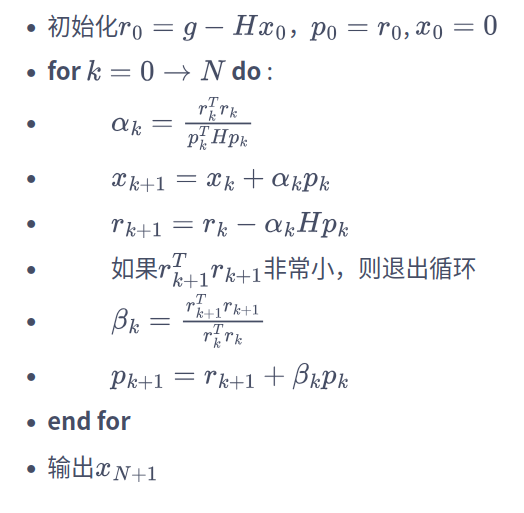  


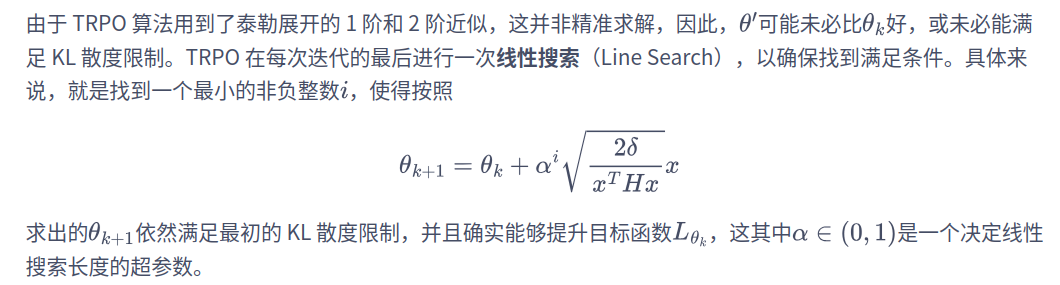

由于每一步都进行了近似，因此迭代过程如下：  
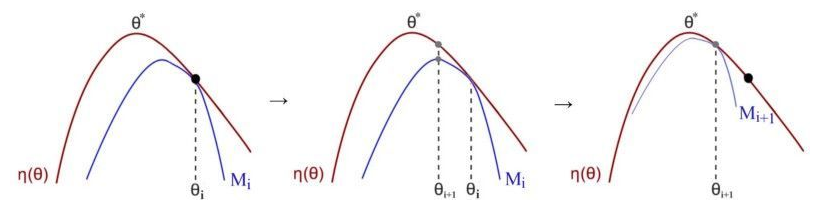

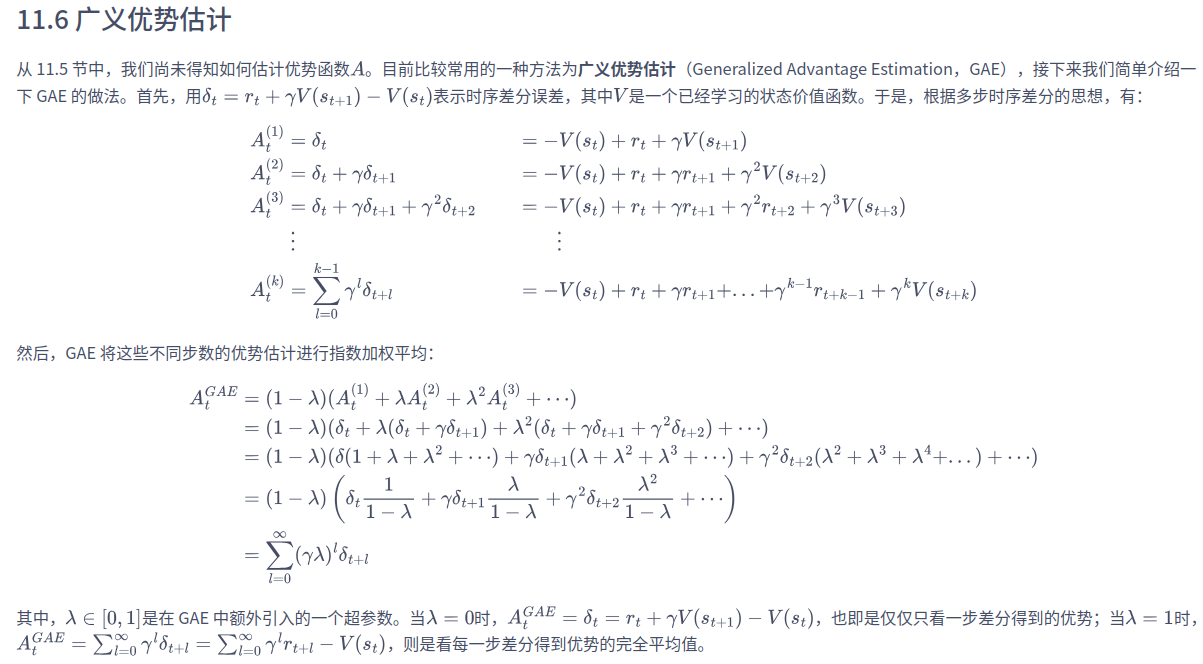

In [2]:
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        # 从尾部到第一个
        advantage = gamma * lmbda * advantage + delta
        # 遍历到的每一步的优势值都只需要使用之前被遍历到的时间步来计算
        advantage_list.append(advantage)
        # 存储从最后一个状态到初始状态的广义优势估计
    advantage_list.reverse()
    # 然后再进行反转(num_episode_step,)
    return torch.tensor(advantage_list, dtype=torch.float)

设计两个网络,策略网络和状态价值网络  
策略网络的优化方法是通过求解不等式约束下最大化优势函数A的最优化问题得到最优策略  
值网络的作用是使用时序差分的方法计算TD_target和TD_error  
然后通过GAE算法来估计优势函数A

In [3]:
import jdc
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)
    # 离散动作,输出一个概率分布

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    # 输出状态值的估计

值网络(critic)的更新方式:  
$$TD\_target=r+\gamma V_w(s_{t+1})$$
Q(s,a)就是TD_target

$$critic\_loss=\frac{1}{2}(TD\_target-V_w(s_t))^2$$
loss里面的TD_target要进行固定作为常数,不对其计算梯度

重要性采样系数计算方法：  
$$\frac{\pi_{\theta}(a|s)}{\pi_{\theta_0}(a|s)}=exp(log(\frac{\pi_{\theta}(a|s)}{\pi_{\theta_0}(a|s)}))=exp(log(\pi_{\theta}(a|s)-log(\pi_{\theta_0}(a|s))$$
其中$\pi_{\theta_0}(a|s)$是实际被选择的动作的概率，从已经采样到的episode里面获得s和a然后用没更新前的策略网络action计算概率$\pi_{\theta_0}(a|s)$

torch.autograd.grad(outputs, inputs)与 backward()的区别：  
torch.autograd.grad直接返回梯度，而 tensor.backward()将梯度累积到相应张量的 .grad属性中  
使用 grad()可以更灵活地计算特定变量的梯度，而不影响原始的 .grad属性  

In [ ]:
class TRPO:
    """ TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        # 策略网络参数不需要优化器更新
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)

        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda  # GAE参数
        self.kl_constraint = kl_constraint  # KL距离最大限制
        self.alpha = alpha  # 线性搜索参数
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
        # 返回一个标量,动作的索引

    """ 传入的是一个episode的数据 """
    def update(self, transition_dict):
        # (num_episode_steps,state_dim)
        states = torch.tensor(transition_dict['states'],dtype=torch.float).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],dtype=torch.float).to(self.device)
        
        # (num_episode_steps,1)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],dtype=torch.float).view(-1, 1).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        # 
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        # 值网络还没更新前的TD_error,从第一步到结束状态
        td_delta = td_target - self.critic(states)
        
        # 策略网络优化，数值使用的是值网络计算的，对于策略网络来说，这些都是常数
        advantage = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # 对输出的动作的概率计算log，使用策略网络计算得到，detach之后变成了标量，只计算实际采取的那个动作的概率
        old_log_probs = torch.log(self.actor(states).gather(1,actions)).detach()
        # 在每一步的状态下根据策略网络输出的概率 生成动作的概率分布
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())

        # 值网络更新
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()  # 更新价值函数

        # 更新策略函数
        self.policy_learn(states, actions, old_action_dists, old_log_probs,advantage)


    def policy_learn(self, states, actions, old_action_dists, old_log_probs, advantage):  # 更新策略函数
        # 输入的所有参数都不计算梯度，对于策略网络来说都是标量
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,old_log_probs, self.actor)#得到一个标量
        # 求目标函数对策略网络的梯度
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        # view(-1)展平成一个一维向量，cat堆叠成一维张量，其实参数的排列顺序无所谓
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        # 只需要这个梯度向量的数值，不要为它构建计算图，detach

        # 用共轭梯度法计算x = H^(-1)g，梯度下降的方向，长度同梯度
        descent_direction = self.conjugate_gradient(obj_grad, states,old_action_dists)

        Hd = self.hessian_matrix_vector_product(states, old_action_dists,descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /(torch.dot(descent_direction, Hd) + 1e-8))# 标量
        
        new_para = self.line_search(states, actions, advantage, old_log_probs,old_action_dists,descent_direction * max_coef)  # 线性搜索

        torch.nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())  # 用线性搜索后的参数更新策略
        


        # 计算策略目标，重要性采样比率（新策略概率与旧策略概率之比）与优势函数的乘积
    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,actor):  
        # states, actions, advantage, old_log_probs的形状均为(num_episode_step,)
        # 更好的策略的概率log
        log_probs = torch.log(actor(states).gather(1, actions))

        ratio = torch.exp(log_probs - old_log_probs)
        # 这里的分布进行了简化，每一步的状态的分布为：当前步所处的状态，概率就是1，其余状态概率为0
        # 总的来说，某一个状态的访问概率是一个episode里该状态出现的次数除以episode的总步数，频率估计概率，动作分布概率同理
        return torch.mean(ratio * advantage)

    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # 计算黑塞矩阵和一个向量的乘积
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        # 已经获得的episode的所有时间步上对应的状态在未更新的policy下的概率分布和新policy对应的概率分布求kl散度
        kl = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists,new_action_dists))  # 计算平均KL距离
        # 每个状态下的动作分布都有一个散度，将结果求均值
        kl_grad = torch.autograd.grad(kl,self.actor.parameters(),create_graph=True)#参数 create_graph=True至关重要，它保留了计算图，以便后续计算二阶导数
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])#一维向量
        # KL距离的梯度先和向量进行点积运算
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        # 第二次求梯度
        grad2 = torch.autograd.grad(kl_grad_vector_product,self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector

    def conjugate_gradient(self, grad, states, old_action_dists):  # 完整版共轭梯度法求解方程
        # 求解方程Hd-g=0的解d，这里x就是d
        x = torch.zeros_like(grad)#初始化为0
        r = grad.clone()# 梯度向量
        p = grad.clone()# 共轭方向
        pdotr = torch.dot(p, r)# alpha的分母
        for i in range(10):  # 共轭梯度主循环
            # 计算H*p_k
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,p)
            # 计算dot(p,r)
            pdotr = torch.dot(p, r)
            alpha = pdotr / torch.dot(p, Hp)
            x += alpha * p# 解更新
            r -= alpha * Hp# 梯度更新
            rdotr = torch.dot(r, r)# 截止条件
            if rdotr < 1e-10:
                break
            Hr=self.hessian_matrix_vector_product(states, old_action_dists,r)
            # 分子是p^T*H*r_(k+1)，分母是p^T*H*p
            beta = torch.dot(p, Hr) / torch.dot(p, Hp)
            p = r + beta * p
        return x

    # def conjugate_gradient(self, grad, states, old_action_dists):  # 简化版的共轭梯度法求解方程
    #     x = torch.zeros_like(grad)
    #     r = grad.clone()
    #     p = grad.clone()
    #     rdotr = torch.dot(r, r)
    #     for i in range(10):  # 共轭梯度主循环
    #         Hp = self.hessian_matrix_vector_product(states, old_action_dists,
    #                                                 p)
    #         alpha = rdotr / torch.dot(p, Hp)
    #         x += alpha * p
    #         r -= alpha * Hp
    #         new_rdotr = torch.dot(r, r)
    #         if new_rdotr < 1e-10:
    #             break
    #         beta = new_rdotr / rdotr
    #         p = r + beta * p
    #         rdotr = new_rdotr
    #     return x

    def line_search(self, states, actions, advantage, old_log_probs, old_action_dists, max_vec):  # 线性搜索
        # 获取旧参数
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        # 旧的目标函数
        old_obj = self.compute_surrogate_obj(states, actions, advantage,old_log_probs, self.actor)
        # 用于迭代计算参数更新后的一些值
        new_actor = copy.deepcopy(self.actor)
        for i in range(15):  # 线性搜索主循环，寻找一个合适的i
            coef = self.alpha**i # 越来越小
            new_para = old_para + coef * max_vec # 参数更新
            torch.nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(new_actor(states))

            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists,new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor)
            # 保证目标函数增大且策略变化不会导致kl差距大
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

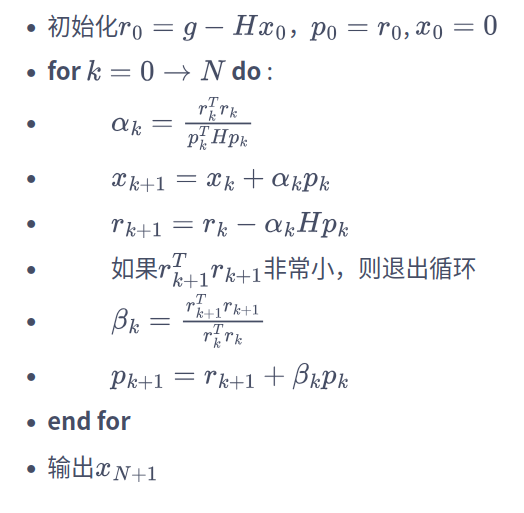

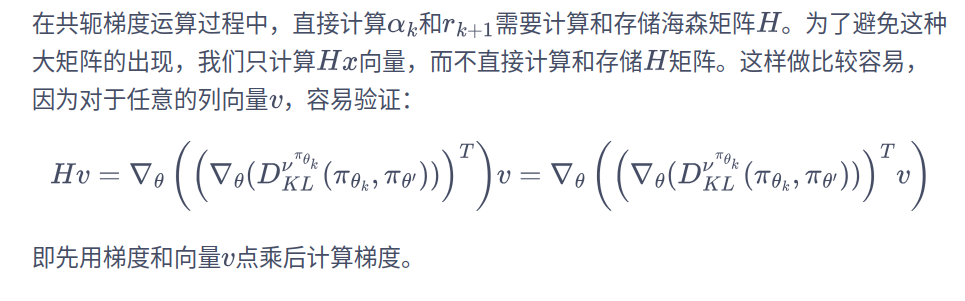

由于每一步都进行了近似，因此迭代过程如下：  
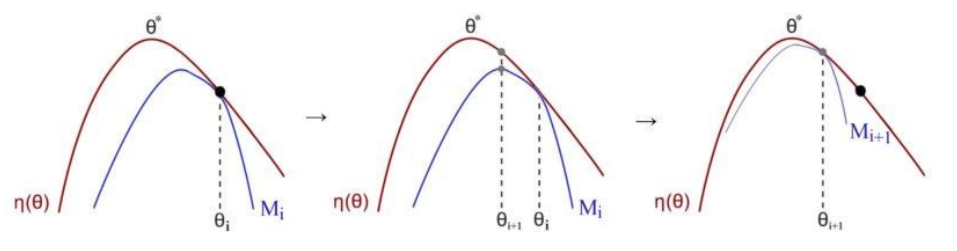

Iteration 0:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_47339/73193618.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647352509/work/torch/csrc/utils/tensor_new.cpp:278.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s, episode=500, return=362.200]


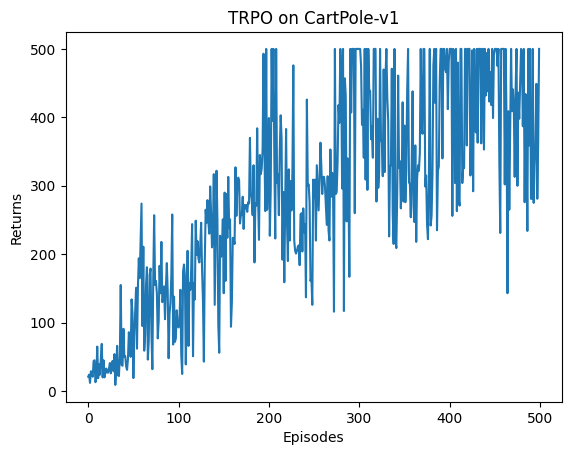

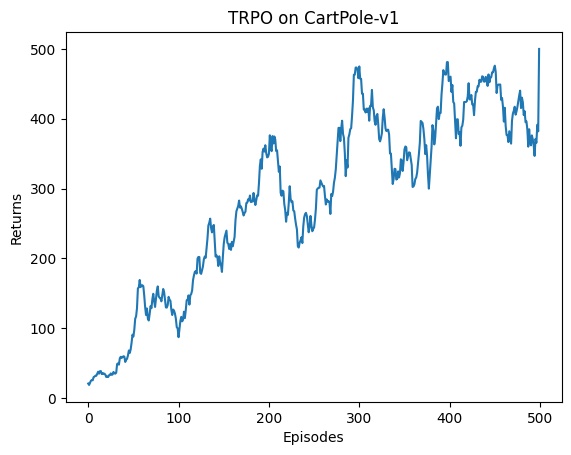

In [5]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPO(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()



In [6]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std  # 高斯分布的均值和标准差


class TRPOContinuous:
    """ 处理连续动作的TRPO算法 """
    def __init__(self, hidden_dim, state_space, action_space, lmbda,
                 kl_constraint, alpha, critic_lr, gamma, device):
        state_dim = state_space.shape[0]
        action_dim = action_space.shape[0]
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)
        action_dist = torch.distributions.Normal(mu, std)
        action = action_dist.sample()
        return [action.item()]

    def hessian_matrix_vector_product(self,
                                      states,
                                      old_action_dists,
                                      vector,
                                      damping=0.1):
        mu, std = self.actor(states)
        new_action_dists = torch.distributions.Normal(mu, std)
        kl = torch.mean(
            torch.distributions.kl.kl_divergence(old_action_dists,
                                                 new_action_dists))
        kl_grad = torch.autograd.grad(kl,
                                      self.actor.parameters(),
                                      create_graph=True)
        kl_grad_vector = torch.cat([grad.view(-1) for grad in kl_grad])
        kl_grad_vector_product = torch.dot(kl_grad_vector, vector)
        grad2 = torch.autograd.grad(kl_grad_vector_product,
                                    self.actor.parameters())
        grad2_vector = torch.cat(
            [grad.contiguous().view(-1) for grad in grad2])
        return grad2_vector + damping * vector

    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists,
                                                    p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10:
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x

    def compute_surrogate_obj(self, states, actions, advantage, old_log_probs,
                              actor):
        mu, std = actor(states)
        action_dists = torch.distributions.Normal(mu, std)
        log_probs = action_dists.log_prob(actions)
        ratio = torch.exp(log_probs - old_log_probs)
        return torch.mean(ratio * advantage)

    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(
            self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage,
                                             old_log_probs, self.actor)
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(
                new_para, new_actor.parameters())
            mu, std = new_actor(states)
            new_action_dists = torch.distributions.Normal(mu, std)
            kl_div = torch.mean(
                torch.distributions.kl.kl_divergence(old_action_dists,
                                                     new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                 old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint:
                return new_para
        return old_para

    def policy_learn(self, states, actions, old_action_dists, old_log_probs,
                     advantage):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantage,
                                                   old_log_probs, self.actor)
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters())
        obj_grad = torch.cat([grad.view(-1) for grad in grads]).detach()
        descent_direction = self.conjugate_gradient(obj_grad, states,
                                                    old_action_dists)
        Hd = self.hessian_matrix_vector_product(states, old_action_dists,
                                                descent_direction)
        max_coef = torch.sqrt(2 * self.kl_constraint /
                              (torch.dot(descent_direction, Hd) + 1e-8))
        new_para = self.line_search(states, actions, advantage, old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(
            new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = compute_advantage(self.gamma, self.lmbda,
                                      td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        old_action_dists = torch.distributions.Normal(mu.detach(),
                                                      std.detach())
        old_log_probs = old_action_dists.log_prob(actions)
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        self.policy_learn(states, actions, old_action_dists, old_log_probs,
                          advantage)

Iteration 9: 100%|██████████| 200/200 [00:33<00:00,  5.93it/s, episode=2000, return=-1097.327]


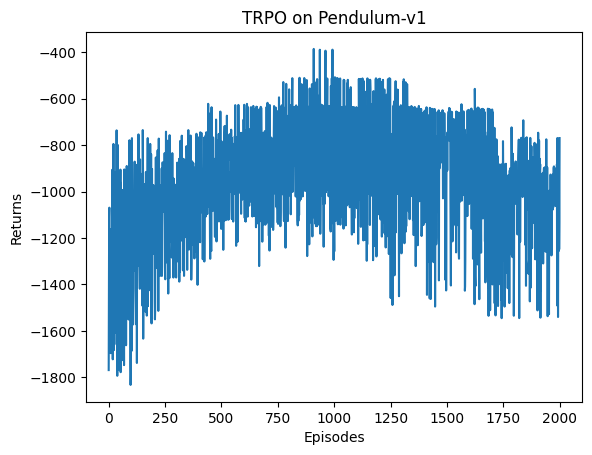

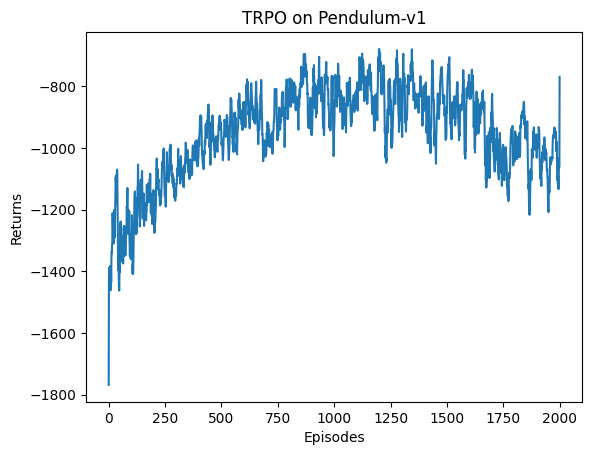

In [7]:
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
critic_lr = 1e-2
kl_constraint = 0.00005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
agent = TRPOContinuous(hidden_dim, env.observation_space, env.action_space,
                       lmbda, kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

